In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
# define in which direction the transformation should start
from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2

# define the two tautomer SMILES
t1_smiles = 'CC(CC(C)=O)=O'
t2_smiles = 'CC(/C=C(/C)\O)=O'

# generate the input
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

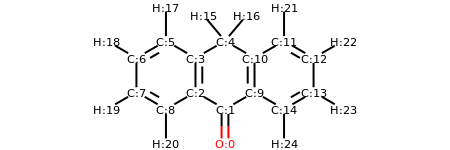

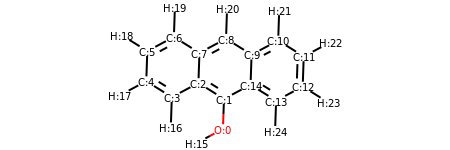

In [3]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

In [4]:
# generate the equilibrium samples to start the NCMC runs
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atom=None)
model = model.to(device)
torch.set_num_threads(2)

energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['atom_list'],
                                          platform = platform,
                                          tautomer_transformation = {})

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)


n_steps = 5000
x0 = np.array(ani_input['coord_list']) * unit.angstrom
equilibrium_samples = langevin.run_dynamics(x0, n_steps)

[utils.py:48 - get_tautomer_transformation()] Index of atom that moves: 16.
[utils.py:54 - get_tautomer_transformation()] Index of atom that donates hydrogen: 4
[utils.py:72 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 0


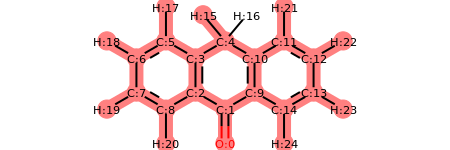

In [5]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atom=tautomer_transformation['hydrogen_idx'])
model = model.to(device)
torch.set_num_threads(2)

In [6]:
# define the number of NCMC pertubation steps
nr_of_mc_trials = 1000
# number of repetitions for the protocol
nr_of_runs = 150
work_in_runs = {}

[mcmc.py:239 - performe_md_mc_protocoll()] Decoupling hydrogen ...
  0%|          | 0/500 [00:00<?, ?it/s]

Hydrogen 16 is moved from atom-idx 4 to atom-idx 0.


100%|██████████| 500/500 [25:47<00:00,  3.11s/it]
[mcmc.py:253 - performe_md_mc_protocoll()] Moving hydrogen ...
[mcmc.py:317 - perform_mc_move()] delta_u : -1.1756
[mcmc.py:260 - performe_md_mc_protocoll()] Work of Hydrogen move: 0.0000
[mcmc.py:261 - performe_md_mc_protocoll()] Recoupling hydrogen ...
100%|██████████| 500/500 [25:55<00:00,  3.00s/it]


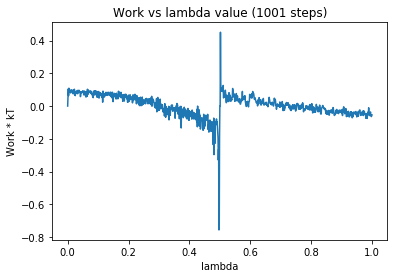

Total work of the protocoll: 3.916585871848263.


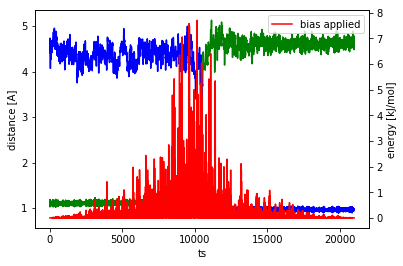

[mcmc.py:239 - performe_md_mc_protocoll()] Decoupling hydrogen ...
  0%|          | 0/500 [00:00<?, ?it/s]

Hydrogen 16 is moved from atom-idx 4 to atom-idx 0.


  1%|          | 5/500 [00:12<21:53,  2.65s/it]

In [ ]:
# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology

for run_nr in range(nr_of_runs):

    energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                              model = model,
                                              atom_list = ani_input['atom_list'],
                                              platform = platform,
                                              tautomer_transformation = tautomer_transformation)
    
    langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['atom_list'],
                                temperature = 300*unit.kelvin,
                                force = energy_function)

    hydrogen_mover = neutromeratio.NonequilibriumMC(donor_idx = tautomer_transformation['donor_idx'], 
                                           hydrogen_idx = tautomer_transformation['hydrogen_idx'], 
                                           acceptor_idx = tautomer_transformation['acceptor_idx'], 
                                           atom_list = ani_input['atom_list'], 
                                           energy_function = energy_function,
                                           langevin_dynamics= langevin)

    # initial conditions: coordinates from example were given in units of angstroms   
    x0 = random.choice(equilibrium_samples) 

    print(f"Hydrogen {hydrogen_mover.hydrogen_idx} is moved from atom-idx {hydrogen_mover.donor_idx} to atom-idx {hydrogen_mover.acceptor_idx}.")

    # run MD and MC protocoll
    work, traj = hydrogen_mover.performe_md_mc_protocoll(x0 = x0, nr_of_mc_trials = nr_of_mc_trials)    
    work = work['work']

    work_in_runs[run_nr] = work

    # save trajectory
    ani_traj = md.Trajectory(traj, topology)
    ani_traj.save(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.dcd")

    # save work values (overwriting after each new run)
    f = open(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.csv", 'w+')
    for i, j in enumerate(work):
        f.write('{}, {}\n'.format(i, j))
    f.close()

    plt.plot(np.linspace(0, 1, len(work)), work)
    plt.xlabel('lambda')
    plt.ylabel('Work * kT')
    plt.title('Work vs lambda value ({} steps)'.format(len(work)))
    plt.savefig(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.png")
    plt.show()
    
    print('Total work of the protocoll: {}.'.format(sum(work)))
    distance_list_h_donor = []
    distance_list_h_acceptor = []
    for x in traj:
        distance_list_h_donor.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['donor_idx']]))
        distance_list_h_acceptor.append(neutromeratio.constants.nm_to_angstroms * np.linalg.norm(x[tautomer_transformation['hydrogen_idx']] - x[tautomer_transformation['acceptor_idx']]))

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(distance_list_h_donor, label='distance between donor and hydrogen', color='g')
    ax1.plot(distance_list_h_acceptor, label='distance between acceptor and hydrogen', color='b')
    ax2.plot(energy_function.bias_applied, label='bias applied', color='r')
    ax1.set_xlabel('ts')
    ax1.set_ylabel('distance [A]')
    ax2.set_ylabel('energy [kJ/mol]')
    plt.legend()
    plt.savefig(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_distance_run_nr_{run_nr}.png")
    plt.show()
